In [1]:
# Import library depdendencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
# Import flapping_fin_data
data = pd.read_csv("data/aerodynamic_data_set_with_labels.csv")

data.head()

,rle,xup,yup,yxxup,xlo,ylo,yxxlo,alpha_te,beta_te,CL,CD,CM
0,0.00784,0.43320,0.062900,-0.424500,0.36180,-0.058900,0.706900,-0.11260,0.16460,0.808246,0.007262,0.121544
1,0.00852,0.38988,0.069190,-0.466950,0.39798,-0.064790,0.777590,-0.12386,0.14814,0.800081,0.018035,0.126753
2,0.00716,0.47652,0.056610,-0.382050,0.32562,-0.053010,0.636210,-0.10134,0.18106,0.779725,0.003612,0.110895
3,0.00750,0.41154,0.066045,-0.488175,0.41607,-0.050065,0.600865,-0.10697,0.13991,0.796090,0.012809,0.118196
4,0.00886,0.49818,0.053465,-0.403275,0.34371,-0.061845,0.742245,-0.12949,0.17283,0.764920,0.007443,0.107714


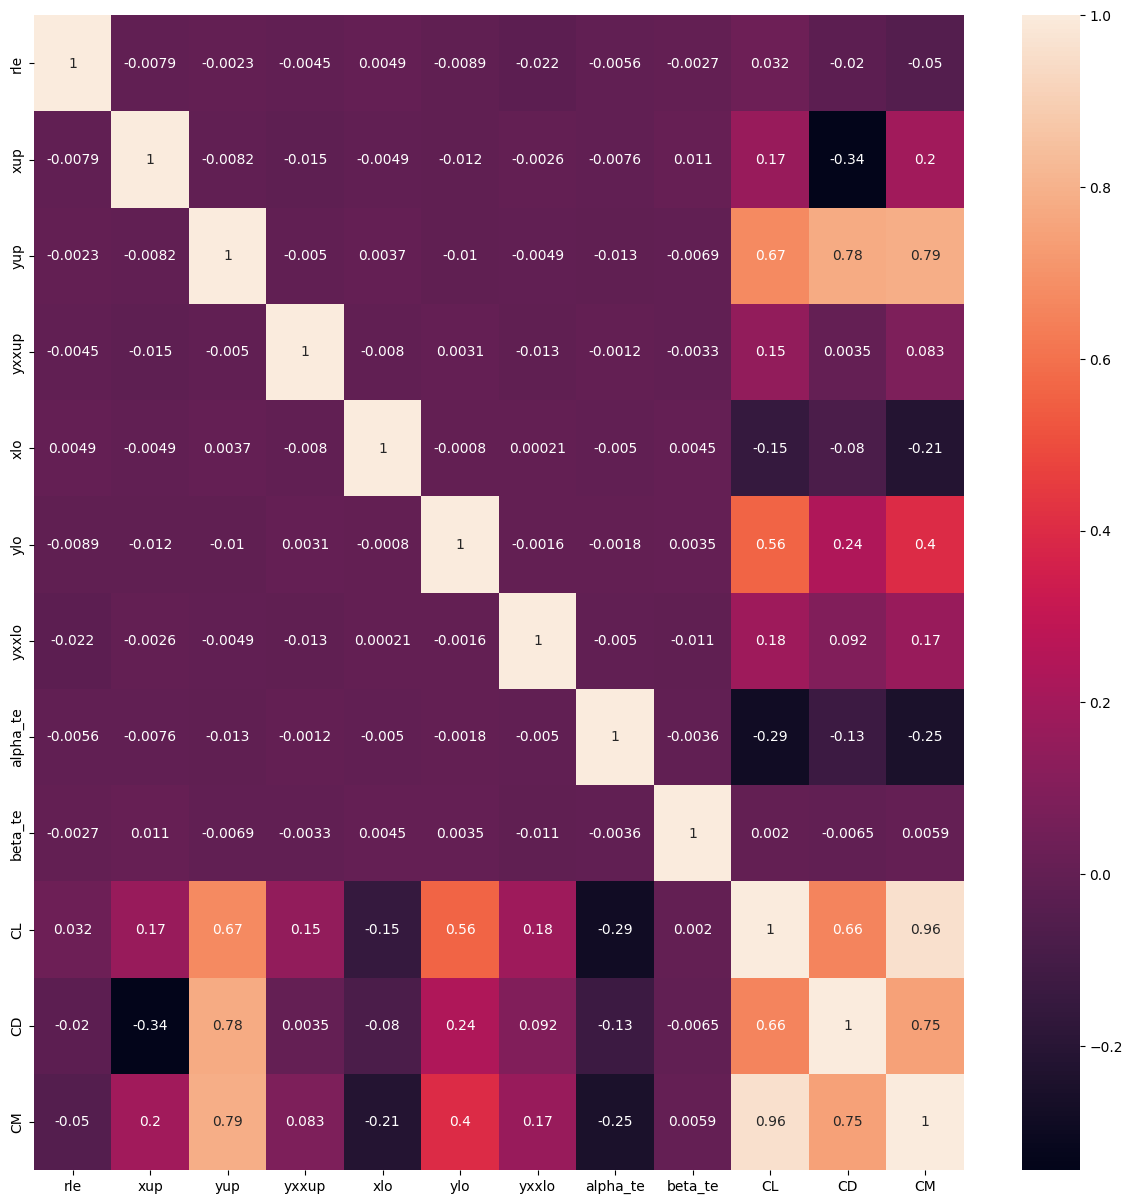

In [3]:
# Check correlation
corr_matrix = data.corr()

fig = plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True)

plt.show()

In [4]:
# Split input and output variable
y = data[["CL", "CD", "CM"]]
X = data.drop(["CL", "CD", "CM"],axis=1)

In [5]:
# Split train-test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Scale the input data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Use regression model
from sklearn.linear_model import LinearRegression

lr_scaled = LinearRegression()

lr_scaled.fit(X_train_scaled, y_train)

y_pred_lr_scaled = lr_scaled.predict(X_test_scaled)

In [8]:
# Check regression coefficient to rank importance
coef = pd.DataFrame(lr_scaled.coef_)
coef.columns = X.columns
coef.index = y.columns

In [9]:
coef.loc["CL"].sort_values()

alpha_te   -0.106844
xlo        -0.056859
beta_te     0.000990
rle         0.015327
yxxup       0.061700
xup         0.067050
yxxlo       0.070369
ylo         0.218297
yup         0.262981
Name: CL, dtype: float64

In [10]:
coef.loc["CD"].sort_values()

xup        -0.008393
alpha_te   -0.002914
xlo        -0.002316
rle        -0.000743
beta_te     0.000068
yxxup       0.000300
yxxlo       0.002257
ylo         0.005832
yup         0.019623
Name: CD, dtype: float64

In [11]:
coef.loc["CM"].sort_values()

alpha_te   -0.029773
xlo        -0.027011
rle        -0.005643
beta_te     0.001082
yxxup       0.011799
yxxlo       0.020989
xup         0.026017
ylo         0.051075
yup         0.099483
Name: CM, dtype: float64

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Create new a knn model
knn2 = KNeighborsRegressor()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# Use GridSearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)

# Fit model to data
knn_gscv.fit(X, y)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [13]:
knn_gscv.best_params_["n_neighbors"]

5

In [14]:
# Use KNN model
knn = KNeighborsRegressor(n_neighbors=knn_gscv.best_params_["n_neighbors"])

knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

In [37]:
# Test the score
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr_scaled_mae = mean_absolute_error(y_pred_lr_scaled, y_test)
lr_scaled_rmse = mean_squared_error(y_pred_lr_scaled, y_test, squared=False)
knn_mae = mean_absolute_error(y_pred_knn, y_test)
knn_rmse = mean_squared_error(y_pred_knn, y_test, squared=False)

scores = pd.DataFrame({
    "Model": ("LR", "LR", "KNN", "KNN"), 
    "Score": ("MAE", "RMSE", "MAE", "RMSE"), 
    "Value": (lr_scaled_mae, lr_scaled_rmse, knn_mae, knn_rmse)
})

In [38]:
scores.set_index(["Model", "Score"], inplace=True)

In [39]:
scores

Value
Model Score          
LR    MAE    0.007245
      RMSE   0.009932
KNN   MAE    0.017054
      RMSE   0.020753

In [40]:
# Predict the whole dataset
y_lr = lr_scaled.predict(scaler.transform(X))
y_lr_df = pd.DataFrame(y_lr)
y_lr_df.columns = y.columns
y_lr_df.index = y.index

In [41]:
# Get R2 for each
from sklearn.metrics import r2_score

r2_CL = r2_score(y["CL"], y_lr_df["CL"])
r2_CD = r2_score(y["CD"], y_lr_df["CD"])
r2_CM = r2_score(y["CM"], y_lr_df["CM"])

r2 = pd.DataFrame({
    "Model": ("LR", "LR", "LR"),
    "Score": ("CL", "CD", "CM"),
    "Value": (r2_CL, r2_CD, r2_CM)
})

r2.set_index(["Model", "Score"], inplace=True)

r2

Value
Model Score          
LR    CL     0.968487
      CD     0.809074
      CM     0.973794